## Lab 4 - MNIST

For lab 4, you will complete and submit this ipynb to Canvas by the deadline.

Please see the posted Fashion-MNIST Jupyter Notebook. You should use it as the guideline to complete this Jupyter Notebook. There are many similarities, except a few places that you need to make modifications.

Read the lab description carefully for the instructions. 


In [ ]:
# All the needed imports
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report,f1_score

In [ ]:
# Download training data from open datasets.
# Imports the MNIST dataset from dataset.
training_data = datasets.MNIST(
    root="data", # Location of the dataset
    train=True, # Loads in the training set
    download=True, # Download the dataset if not present in root directory
    transform=ToTensor(), # Converts image data from PIL format to pytorch format
)

# Download test data from open datasets.
test_data = datasets.MNIST( # Imports MNIST test data from datasets.
    root="data", # Location of the dataset
    train=False, # Does not load in the training set
    download=True, # Download the dataset if not present in root directory
    transform=ToTensor(), # Converts image data from PIL format to pytorch format
)

In [ ]:
# Create data loaders.
batch_size = 64 # number of images processed in each iteration of the loop 

# Loads in the training data, with it going through batch_size images per iteration
train_dataloader = DataLoader(training_data, batch_size=batch_size)
# Loads in the testing data, with it going through batch_size images per iteration
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Iterate through test_dataloaders, which the loads the test dataset and 
# returns a batch of data 'x' and corresponding target 'y'
for X, y in test_dataloader:
    # prints X(4D tensor), where N = batch size,C = number of channels,H = height, W = width
    print("Shape of X [N, C, H, W]: ", X.shape)
    # prints y (1d tensor), alongs with the data type of the tensor(integer). 
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [ ]:
# Get cpu or gpu device for training.
# Uses GPU cuda if available, otherwise uses cpu.
device = "cuda" if torch.cuda.is_available() else "cpu"
# prints what device is being used.
print("Using {} device".format(device))

# Define an NN model
class NeuralNetwork(nn.Module):
    # defines layers of the neural network using nn.Module
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # flattens input tensors from 4D to 1D
        self.flatten = nn.Flatten()
        # defines the sequences of layers that will be appplied to the input tensor.
        self.linear_relu_stack = nn.Sequential(
            # First linear transformation that takes an input tensor of [batch_size, 784]
            # and has 512 output features.
            nn.Linear(28*28, 512),
            # applies the ReLU activation function to the output of the Linear() function.
            nn.ReLU(),
            # Second linear transformation takes the output of the first Linear() function
            # and has 512 output features.
            nn.Linear(512, 512),
            # applies the ReLU activation function to the output of the second Linear() function.
            nn.ReLU(),
            # Third linear layer has 10 output features, which correspond 
            # to the 10 classes of the MNIST dataset.
            nn.Linear(512, 10)
        )

    # takes an input tensor 'x' and applies the layers defined in the above function to it.
    def forward(self, x):
      # flattens input x
        x = self.flatten(x)
        # x is passed through the layers defined in linear_relu_stack
        logits = self.linear_relu_stack(x)
        # returns logits tensors
        return logits

# creates an instance of the neural network using the device specified
model = NeuralNetwork().to(device)
# prints the architecture (string representation) of this model
print(model)


Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
# Set the loss and optimizer to be used in the next next cell

# loss_fn uses CrossEntropyLoss() to return the average loss value of all the samples in the batch
loss_fn = nn.CrossEntropyLoss()

# optimizer uses SGD to update the parameters as the model trains itself with a learning rate 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=2e-1)

# set up the learning rate for the optimizer, reducing by 0.1 for every 5 epochs.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
# Define the train and test functions
def train(dataloader, model, loss_fn, optimizer):
    # Get the number of training samples in the dataloader
    size = len(dataloader.dataset)
    # Set the model to training mode, which enables features such as dropout
    model.train()
    # For each batch of data in the dataloader, do the following:
    for batch, (X, y) in enumerate(dataloader):
        # Transfer the data and labels to the device (e.g., CPU or GPU) specified by the "device" variable
        X, y = X.to(device), y.to(device)

        # Compute the model's predictions for the input data X
        pred = model(X)
        # Compute the prediction error (i.e., loss) using the loss function loss_fn
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        # Compute the gradients of the loss with respect to the model parameters
        loss.backward()
        # Update the model parameters using the optimizer (e.g., gradient descent)
        optimizer.step()

        # If the current batch index is a multiple of 100, print the current loss and the number of training samples seen so far
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Defined test function
def test(dataloader, model, loss_fn):
    # Get the number of test samples in the dataloader
    size = len(dataloader.dataset)
    # Get the number of batches in the dataloader
    num_batches = len(dataloader)
    # Set the model to evaluation mode
    model.eval()
    # Initialize variables to track the test loss and the number of correct predictions
    test_loss, correct = 0, 0
    # Turn off autograd during the testing loop to reduce memory usage and speed up computation
    with torch.no_grad():
        # For each batch of data in the dataloader, do the following:
        for X, y in dataloader:
            # Transfer the data and labels to the device (e.g., CPU or GPU) specified by the "device" variable
            X, y = X.to(device), y.to(device)
            # Compute the model's predictions for the input data X
            pred = model(X)
            # Compute the prediction error (i.e., loss) using the loss function loss_fn and accumulate it across all test batches
            test_loss += loss_fn(pred, y).item()
            # Compute the number of correct predictions in the batch and accumulate it across all test batches
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Compute the average test loss across all test batches
    test_loss /= num_batches
    # Compute the accuracy of the model's predictions
    correct /= size
    # Print the accuracy and average test loss
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [ ]:
# Training the NN model 

# Set the number of epochs to train the model for
epochs = 6   #starting with 5 epochs --> may need to adjust
# For each epoch in the range of epochs specified, do the following:
for t in range(epochs):
    # Print which epoch we're currently on
    print(f"Epoch {t+1}\n-------------------------------")
    # Train the model using the training DataLoader
    train(train_dataloader, model, loss_fn, optimizer)
    # Test the model's accuracy using the testing DataLoader
    test(test_dataloader, model, loss_fn)
    # Use the scheduler to update the learning rate for the optimizer
    scheduler.step()
# Print message indicating we are finished training the model
print("Done!")

# I get an accuracy of about 98.2%. This was accomplished by changing the 
# number of epochs, the learning curve and also using a scheduler for the learning curve.
# Changing the number of epochs or the learning curve further did not result in 
# much variance, so the model converges at this accuracy.
# I decided on a (2e-1) learning curve and 6 epochs as that gave the best 
# results while also having a good F1 score and confusion matrix.

Epoch 1
-------------------------------
loss: 2.298631  [    0/60000]
loss: 0.374297  [ 6400/60000]
loss: 0.298180  [12800/60000]
loss: 0.332604  [19200/60000]
loss: 0.176633  [25600/60000]
loss: 0.276787  [32000/60000]
loss: 0.136801  [38400/60000]
loss: 0.231742  [44800/60000]
loss: 0.173258  [51200/60000]
loss: 0.225836  [57600/60000]
Test Error: 
 Accuracy: 94.6%, Avg loss: 0.169471 

Epoch 2
-------------------------------
loss: 0.078143  [    0/60000]
loss: 0.142649  [ 6400/60000]
loss: 0.129822  [12800/60000]
loss: 0.195131  [19200/60000]
loss: 0.079898  [25600/60000]
loss: 0.162144  [32000/60000]
loss: 0.089127  [38400/60000]
loss: 0.158371  [44800/60000]
loss: 0.106786  [51200/60000]
loss: 0.155874  [57600/60000]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.116791 

Epoch 3
-------------------------------
loss: 0.040155  [    0/60000]
loss: 0.081192  [ 6400/60000]
loss: 0.094454  [12800/60000]
loss: 0.131873  [19200/60000]
loss: 0.051257  [25600/60000]
loss: 0.104558  [32000/600

In [ ]:
# Saving the model in a file, we will use it in the next cell
torch.save(model.state_dict(), "model.pth")
# Print a message that indicated it has been saved.
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
# Using the model for some testing
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

# Define a list of classes for the output labels
classes = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
]

# For each of the first 20 test cases, do the following:
for i in range(20):
  # Set the model to evaluation mode
  model.eval()
  # Get the input and output values for the test case
  x, y = test_data[i][0], test_data[i][1]
  # Compute the predicted output for the test case using the model
  with torch.no_grad():
      # Compute the model's predictions for the input data x
      pred = model(x)
      # Map the predicted and actual output values to their corresponding class labels
      predicted, actual = classes[pred[0].argmax(0)], classes[y]
      # Print the predicted and actual output for the test case
      print(f'Predicted: "{predicted}", Actual: "{actual}"')


Predicted: "7", Actual: "7"
Predicted: "2", Actual: "2"
Predicted: "1", Actual: "1"
Predicted: "0", Actual: "0"
Predicted: "4", Actual: "4"
Predicted: "1", Actual: "1"
Predicted: "4", Actual: "4"
Predicted: "9", Actual: "9"
Predicted: "5", Actual: "5"
Predicted: "9", Actual: "9"
Predicted: "0", Actual: "0"
Predicted: "6", Actual: "6"
Predicted: "9", Actual: "9"
Predicted: "0", Actual: "0"
Predicted: "1", Actual: "1"
Predicted: "5", Actual: "5"
Predicted: "9", Actual: "9"
Predicted: "7", Actual: "7"
Predicted: "3", Actual: "3"
Predicted: "4", Actual: "4"


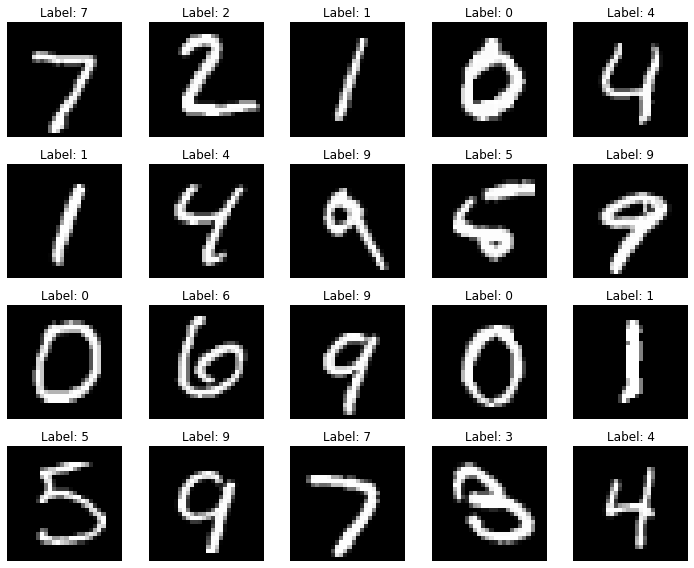

In [ ]:
# Plot the test images used in the previous cell
batch = next(iter(test_dataloader))

# Get the first 20 images and labels
images = batch[0][:20]
labels = batch[1][:20]

# Display the images
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))

# Iterate over each image in the batch and plot it with its label as the title
for i, ax in enumerate(axes.flat):
    # Convert the image from tensor format to a numpy array and then permute its dimensions to display it as an image
    ax.imshow(images[i].permute(1, 2, 0), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

# Adjust the spacing between the subplots and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Include more testing and visualization here
y_pred = []
# Compute the predicted output for the test case using the model
with torch.no_grad():
    # Loop through the batches in test dataloader
    for batch in test_dataloader:
        # Extract the images and labels from the batch
        images, labels = batch
        # Pass the images through the model to get the predicted outputs
        outputs = model(images)
        # Get the index of the maximum value in the outputs, which corresponds to the predicted label
        _, predicted = torch.max(outputs.data, 1)
        # Append the predicted label to the y_pred list
        y_pred.extend(predicted.numpy())

# Get the true labels from the test set
y_true = []
# Loop through the batches in test dataloader
for batch in test_dataloader:
    # Extract the labels from the batch
    _, labels = batch
    # Append the labels to the y_true list
    y_true.extend(labels.numpy())

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Print the confusion matrix
print(f"Confusion matrix is: \n {cm} \n")

# Generate a classification report using the true labels and predicted labels
report = classification_report(y_true, y_pred)
# Print the classification report
print(f"Classification report: \n {report}\n")

# Compute the F1 score using the true labels and predicted labels
f1 = f1_score(y_true, y_pred, average='micro')
# Print the F1 score
print(f"F1 score is: \n {f1} \n")



Confusion matrix is: 
 [[ 969    0    0    1    2    0    1    1    4    2]
 [   0 1128    1    2    0    0    2    0    2    0]
 [   4    2 1010    3    3    0    1    4    5    0]
 [   1    0    5  993    0    5    0    1    3    2]
 [   1    0    3    0  966    0    3    1    0    8]
 [   2    0    0    6    1  875    3    0    3    2]
 [   4    3    0    1    5    5  938    0    2    0]
 [   0    6    7    1    0    0    0 1006    3    5]
 [   3    0    3    3    2    3    2    2  953    3]
 [   2    2    0    6   11    1    1    5    1  980]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0